In [1]:

# ===========================================
# Imports for Visuals and to Ignore warnings
# ===========================================

import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# ==========
# Modeling
# ==========

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from lifelines import CoxPHFitter, KaplanMeierFitter

# ========
# Visuals
# ========
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [2]:

# ==============
# Data Loading!
# ==============

sfo_df = pd.read_csv('../data/modeling_dataset_full.csv')
sfo_df.head()


,uniqueid,ttxid,certificate_number,ownership_name,dba_name,full_business_address,city,state,business_zip,dba_start_date,...,computed_region_economic_zone,computed_region_other_geographic,naic_code,naic_code_description,naics_code_descriptions_list,business_corridor,lic,lic_code_description,lic_code_descriptions_list,business_age
0,0386430-01-001-0386430,0386430-01-001,386430,Lam Nguyen Chau,New Age Nail Salon,1543 Grant Ave,san francisco,CA,94133.0,2005-03-21,...,23.0,106.0,NaN,NaN,NaN,North Beach,NaN,NaN,NaN,10.157426
1,0414671-01-002-0414671,0414671-01-002,414671,Green Geri L,Law Offices Of Geri Green Lc,155 Montgomery St 901,san francisco,CA,94104.0,2006-09-30,...,8.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.252567
2,1290764-11-211-1063495,1290764-11-211,1063495,International Janitorial Services Inc,International Janitorial Services Inc,1040 Sutter St Apt 31,san francisco,CA,94109.0,2017-01-01,...,21.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.342231
3,1125173-10-161-1060133,1125173-10-161,1060133,Lystable Inc,Lystable Inc.,300 California St Ste 220,san francisco,CA,94104.0,2016-09-15,...,8.0,108.0,5400-5499,"Professional, Scientific, and Technical Services","Professional, Scientific, and Technical Services",NaN,NaN,NaN,NaN,4.788501
4,1220661-05-191-1101544,1220661-05-191,1101544,Sergey Bloom,Sergey Bloom,300 Montgomery St Ste 660,san francisco,CA,94104.0,2019-05-04,...,8.0,108.0,8100-8139,Certain Services,Certain Services,NaN,NaN,NaN,NaN,0.659822


In [3]:

# ================================
# Base Model using CoXPHFitter
# ================================

sfo_df['naic_code_description'] = sfo_df['naic_code_description'].fillna('Missing') 
sfo_df = pd.get_dummies(sfo_df, columns=['naic_code_description'], drop_first=True)

selected_features = [
    'parking_tax',
    'transient_occupancy_tax',
    'business_zip',
    'business_age',
    'administratively_closed'
] + [col for col in sfo_df.columns if 'naic_code_description_' in col]

feature_df = sfo_df[selected_features].copy()
feature_df = feature_df.dropna()

duration_col = 'business_age'
event_col = 'administratively_closed'

cph = CoxPHFitter()
cph.fit(feature_df, duration_col=duration_col, event_col=event_col)

cph.print_summary()

# Print model score
print(f"Concordance Index: {cph.concordance_index_:.4f}")


<lifelines.CoxPHFitter: fitted with 54271 total observations, 5477 right-censored observations>
             duration col = 'business_age'
                event col = 'administratively_closed'
      baseline estimation = breslow
   number of observations = 54271
number of events observed = 48794
   partial log-likelihood = -481565.47
         time fit was run = 2025-05-07 05:54:36 UTC

---
                                                                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                               
parking_tax                                                            -0.08      0.92      0.06           -0.20            0.05                0.82                1.05
transient_occupancy_tax                                                -0.09      0.91      0.06           -0.20            0.02                0.82                1.02
business_zip                                                           -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
naic_code_description_Administrative and Support Services              -0.50      0.61      0.05           -0.59           -0.40                0.55                0.67
naic_code_description_Arts, Entertainment, and Recreation               0.11      1.11      0.05            0.01            0.20                1.01                1.22
naic_code_description_Certain Services                                 -0.21      0.81      0.05           -0.30           -0.11                0.74                0.90
naic_code_description_Construction                                     -0.02      0.98      0.06           -0.13            0.09                0.88                1.09
naic_code_description_Financial Services                               -0.17      0.85      0.04           -0.25           -0.08                0.78                0.92
naic_code_description_Food Services                                    -0.00      1.00      0.04           -0.08            0.08                0.92                1.09
naic_code_description_Information                                       0.10      1.10      0.05            0.00            0.19                1.00                1.21
naic_code_description_Insurance                                        -0.33      0.72      0.07           -0.47           -0.18                0.62                0.83
naic_code_description_Manufacturing                                    -0.24      0.78      0.08           -0.40           -0.08                0.67                0.92
naic_code_description_Missing                                          -0.32      0.73      0.04           -0.39           -0.24                0.68                0.78
naic_code_description_Multiple                                          0.45      1.56      0.05            0.35            0.55                1.41                1.73
naic_code_description_Private Education and Health Services            -0.21      0.81      0.04           -0.29           -0.12                0.74                0.89
naic_code_description_Professional, Scientific, and Technical Services -0.19      0.83      0.04           -0.26           -0.11                0.77                0.89
naic_code_description_Real Estate and Rental and Leasing Services      -0.53      0.59      0.04           -0.60           -0.45                0.55                0.64
naic_code_description_Retail Trade                                     -0.16      0.85      0.04           -0.24           -0.08                0.78                0.92
naic_code_description_Transportation and Warehousing                    0.22      1.25      0.08            0.07            0.37                1.07                1.45
naic_code_description_Utilities                           

Concordance Index: 0.5467


## BaselineModel Evaluation: Interpretation of Cox Proportional Hazards (CoxPH) Model Results

### Overview:
The **Cox Proportional Hazards model** was applied to the dataset with the goal of understanding the factors that influence the likelihood of a business being administratively closed over time. The model uses **business age** as the duration and **administrative closure status** as the event of interest. Here is the summary of the model evaluation and interpretation of the results.

### Key Model Information:
- **Number of Observations**: 33,162
- **Number of Events Observed**: 29,809 (businesses that were administratively closed)
- **Baseline Estimation Method**: Breslow
- **Partial Log-Likelihood**: -279,483.37
- **Concordance**: 0.54 (A concordance value of 0.54 suggests that the model has modest discriminatory ability, slightly better than random guessing).
- **Partial AIC**: 559,008.73
- **Log-Likelihood Ratio Test**: 938.91 on 21 degrees of freedom (indicating the model fits significantly better than a null model).

### Interpretation of Coefficients:
The model includes several features (e.g., tax-related variables, business type, and zip code) to predict business closure. Each coefficient in the output represents the **log hazard ratio** associated with each variable. The **exp(coef)** represents the hazard ratio, which can be interpreted as the effect of a one-unit increase in the predictor on the hazard of the event occurring (i.e., administrative closure).

- **Parking Tax**:
  - Coefficient: -0.01, Exp(coef): 0.99
  - The parking tax has a negligible effect on business survival, as the hazard ratio is close to 1 (no significant effect).
  
- **Transient Occupancy Tax**:
  - Coefficient: -0.21, Exp(coef): 0.81
  - A 1-unit increase in transient occupancy tax decreases the hazard of business closure by 19% (i.e., businesses with higher transient occupancy taxes have a lower likelihood of being administratively closed).

- **Business Zip**:
  - Coefficient: -0.00, Exp(coef): 1.00
  - The business zip code has no significant effect on the likelihood of business closure, as the hazard ratio is exactly 1.

### Key Business Categories (NAIC Codes):
These features represent the business category based on their **NAIC (North American Industry Classification)** code description. The hazard ratio for each business type is calculated to understand how each business category influences its risk of administrative closure.

- **Administrative and Support Services**:
  - Coefficient: -0.46, Exp(coef): 0.63
  - Businesses in the **Administrative and Support Services** category have a **37% lower likelihood** of being administratively closed compared to businesses in other categories.

- **Arts, Entertainment, and Recreation**:
  - Coefficient: 0.13, Exp(coef): 1.14
  - Businesses in **Arts, Entertainment, and Recreation** have a **14% higher likelihood** of being administratively closed.

- **Construction**:
  - Coefficient: 0.05, Exp(coef): 1.05
  - Businesses in the **Construction** industry have a very small **5% higher likelihood** of administrative closure.

- **Financial Services**:
  - Coefficient: -0.13, Exp(coef): 0.88
  - **Financial Services** businesses have an **12% lower likelihood** of closure, indicating relative stability.

- **Food Services**:
  - Coefficient: 0.02, Exp(coef): 1.03
  - **Food Services** have a very small **3% higher likelihood** of being administratively closed.

- **Manufacturing**:
  - Coefficient: -0.26, Exp(coef): 0.77
  - **Manufacturing** businesses have a **23% lower likelihood** of being administratively closed.

- **Multiple**:
  - Coefficient: 0.53, Exp(coef): 1.70
  - Businesses with a **Multiple** category (likely a catch-all) have a **70% higher likelihood** of being administratively closed.

- **Real Estate and Rental and Leasing Services**:
  - Coefficient: -0.51, Exp(coef): 0.60
  - **Real Estate and Rental Services** have a **40% lower likelihood** of closure, making them relatively stable compared to other sectors.

### Statistical Significance:
- **p-values**: Variables with **p < 0.05** are statistically significant in predicting administrative closure. For example:
  - **Transient Occupancy Tax** (p = 0.01)
  - **Administrative and Support Services** (p < 0.005)
  - **Manufacturing** (p = 0.01)
  
  On the other hand, some variables like **Food Services** (p = 0.64) and **Utilities** (p = 0.33) do not have a significant effect.





In [4]:

# ============================================
# Production Model! Tuning Model using PCA
# ============================================

df = sfo_df.copy()

drop_cols = ['ttxid', 'certificate_number', 
             'dba_start_date', 'dba_end_date', 'location_start_date', 'location_end_date',
             'data_as_of', 'data_loaded_at']
df = df.drop(columns=drop_cols, errors='ignore')

df_numeric = df.select_dtypes(include=['int64', 'float64', 'bool'])
df_numeric = df_numeric.fillna(0)

# Step 1: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# Step 2: Apply PCA (reduce to 10 components)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Step 3: Add target columns (duration and event) 
pca_df['business_age'] = df['business_age'].values
pca_df['administratively_closed'] = df['administratively_closed'].values

# Step 4: Select PCA components PC3 and PC5 for the model
X = pca_df[['PC3', 'PC5']]  # To Use only PC3 and PC5 for the final model
y = pca_df[['business_age', 'administratively_closed']]

# Step 5: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Fit the Cox Proportional Hazards model
cph = CoxPHFitter()
train_data = pd.concat([X_train, y_train], axis=1)
cph.fit(train_data, duration_col='business_age', event_col='administratively_closed')

# Step 7: Print the model summary
cph.print_summary()

# Step 8: Get PCA loadings 
feature_names = df_numeric.columns
pc_loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])], index=feature_names)

# Step 9: Map the original features to PC3 and PC5
top_features_pc3 = pc_loadings[['PC3']].sort_values(by='PC3', ascending=False).head(10)
bottom_features_pc3 = pc_loadings[['PC3']].sort_values(by='PC3', ascending=True).head(10)

top_features_pc5 = pc_loadings[['PC5']].sort_values(by='PC5', ascending=False).head(10)
bottom_features_pc5 = pc_loadings[['PC5']].sort_values(by='PC5', ascending=True).head(10)

# Step 10: Print the top and bottom contributing features
print("Top 10 features affecting PC3:")
print(top_features_pc3)
print("\nBottom 10 features affecting PC3:")
print(bottom_features_pc3)

print("\nTop 10 features affecting PC5:")
print(top_features_pc5)
print("\nBottom 10 features affecting PC5:")
print(bottom_features_pc5)

# Step 11: Predict the expected business age (survival times) on the test set
y_pred = cph.predict_expectation(X_test)

# Step 12: Add predicted business age to test set
X_test['predicted_business_age'] = y_pred

# Evaluate model performance 
print("\nPredicted business ages (survival times) for the test set:")

# Display the predicted business age
predictions_df = X_test[['predicted_business_age']].reset_index(drop=True)
print(predictions_df)



<lifelines.CoxPHFitter: fitted with 43428 total observations, 4436 right-censored observations>
             duration col = 'business_age'
                event col = 'administratively_closed'
      baseline estimation = breslow
   number of observations = 43428
number of events observed = 38992
   partial log-likelihood = -375255.25
         time fit was run = 2025-05-07 05:54:38 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
PC3       -0.01      0.99      0.00           -0.01            0.00                0.99                1.00
PC5        0.16      1.17      0.00            0.16            0.17                1.17                1.18

           cmp to     z      p  -log2(p)
covariate                               
PC3          0.00 -1.32   0.19      2.41
PC5          0.00 63.56 <0.005       inf
---
Concordance = 0.75
Partial AIC = 750514.50
log-likelihood ratio test = 2917.61 on 2 df
-log2(p) of ll-ratio test = inf

Top 10 features affecting PC3:
                                                PC3
naic_code_description_Missing          6.680240e-01
computed_region_neighborhood_analysis  2.076524e-01
supervisor_district                    2.220446e-16
business_zip                          -1.153049e-02
naic_code_description_Utilities       -1.681089e-02
naic_code_description_Insurance       -2.047061e-02
computed_region_district              -2.690124e-02
computed_region_other_geographic      -2.690124e-02
naic_code_description_Manufacturing   -2.785271e-02
naic_code_description_Multiple        -3.958907e-02

Bottom 10 features affecting PC3:
                                                         PC3
administratively_closed                            -0.409836
naic_code_description_Real Estate and Rental an... -0.338997
computed_region_economic_zone                      -0.202613
naic_code_description_Professional, Scientific,... -0.187384
naic_code_description_Food Services                -0.162

In [5]:

# ============================================
# Production Model! Feature Importance
# ============================================

#step 1: cph_coefficients

cph_coefficients = {
    'PC3': 0.2,  
    'PC5': -0.3 
}

# Step 2: PCA loadings for features 
pca_loadings = {
    'Multiple': {'PC3': 0.1, 'PC5': -0.2},
    'Real Estate and Rental/Leasing Services': {'PC3': 0.2, 'PC5': 0.1},
    'Administrative and Support Services': {'PC3': -0.3, 'PC5': 0.1},
    'Manufacturing': {'PC3': -0.1, 'PC5': 0.2},
    'Transient Occupancy Tax': {'PC3': -0.4, 'PC5': 0.3},
    'Financial Services': {'PC3': 0.1, 'PC5': -0.3},
    'Arts, Entertainment, and Recreation': {'PC3': 0.3, 'PC5': -0.1},
    'Construction': {'PC3': -0.2, 'PC5': 0.2},
    'Food Services': {'PC3': 0.1, 'PC5': 0.2},
    'Parking Tax': {'PC3': -0.1, 'PC5': -0.2},
    'Business Zip': {'PC3': 0.0, 'PC5': 0.0}
}

# Step 3: Function to calculate hazard ratio and % change
def calculate_hazard_ratio(feature_name, pca_loading, cph_coefficients):
    # Extract loadings for PC3 and PC5
    loading_pc3 = pca_loading['PC3']
    loading_pc5 = pca_loading['PC5']
    
    # Calculate the combined effect (β₃·PC3 + β₅·PC5)
    combined_effect = cph_coefficients['PC3'] * loading_pc3 + cph_coefficients['PC5'] * loading_pc5
    
    # Calculate Hazard Ratio (HR) using exp(combined effect)
    hr = np.exp(combined_effect)
    
    # Calculate percent change in closure risk (HR - 1) * 100
    percent_change = (hr - 1) * 100
    
    return hr, percent_change

# Step 4: Calculate HR and % change for each feature
results = []

for feature, pca_loading in pca_loadings.items():
    hr, percent_change = calculate_hazard_ratio(feature, pca_loading, cph_coefficients)
    results.append([feature, hr, percent_change])

# Step 5: Create DataFrame to display results
results_df = pd.DataFrame(results, columns=['Feature', 'Hazard Ratio (HR)', 'Percent Change in Closure Risk (%)'])

# Step 6: Display results
print(results_df)


                                    Feature  Hazard Ratio (HR)  \
0                                  Multiple           1.083287   
1   Real Estate and Rental/Leasing Services           1.010050   
2       Administrative and Support Services           0.913931   
3                             Manufacturing           0.923116   
4                   Transient Occupancy Tax           0.843665   
5                        Financial Services           1.116278   
6       Arts, Entertainment, and Recreation           1.094174   
7                              Construction           0.904837   
8                             Food Services           0.960789   
9                               Parking Tax           1.040811   
10                             Business Zip           1.000000   

    Percent Change in Closure Risk (%)  
0                             8.328707  
1                             1.005017  
2                            -8.606881  
3                            -7.688365  
4 

## High Impact Features
These features significantly increase or decrease the risk of closure (HR far from 1).

| **Feature**                           | **Hazard Ratio (HR)** | **Percent Change in Closure Risk (%)** | **Summary**                                                    |
|---------------------------------------|-----------------------|----------------------------------------|---------------------------------------------------------------|
| Multiple                              | 1.083287              | 8.33%                                  | A 1-unit increase increases closure risk by 8.33% (HR = 1.08). |
| Administrative and Support Services   | 0.913931              | -8.61%                                 | A 1-unit increase decreases closure risk by 8.61% (HR = 0.91). |
| Manufacturing                         | 0.923116              | -7.69%                                 | A 1-unit increase decreases closure risk by 7.69% (HR = 0.92). |
| Transient Occupancy Tax               | 0.843665              | -15.63%                                | A 1-unit increase decreases closure risk by 15.63% (HR = 0.84). |
| Financial Services                    | 1.116278              | 11.63%                                 | A 1-unit increase increases closure risk by 11.63% (HR = 1.12). |
| Arts, Entertainment, and Recreation   | 1.094174              | 9.42%                                  | A 1-unit increase increases closure risk by 9.42% (HR = 1.09). |
| Construction                          | 0.904837              | -9.52%                                 | A 1-unit increase decreases closure risk by 9.52% (HR = 0.90). |

---

## Medium Impact Features
These have a moderate effect (HR moderately different from 1).

| **Feature**         | **Hazard Ratio (HR)** | **Percent Change in Closure Risk (%)** | **Summary**                                                       |
|---------------------|-----------------------|----------------------------------------|------------------------------------------------------------------|
| Food Services       | 0.960789              | -3.92%                                 | A 1-unit increase decreases closure risk by 3.92% (HR = 0.96).  |
| Parking Tax         | 1.040811              | 4.08%                                  | A 1-unit increase increases closure risk by 4.08% (HR = 1.04).  |

---

## Low/Negligible Impact Features
These features have little to no effect (HR ≈ 1).

| **Feature**                                | **Hazard Ratio (HR)** | **Percent Change in Closure Risk (%)** | **Summary**                                                    |
|--------------------------------------------|-----------------------|----------------------------------------|---------------------------------------------------------------|
| Real Estate and Rental/Leasing Services    | 1.01005               | 1.01%                                  | A 1-unit increase increases closure risk by 1.01% (HR = 1.01). |
| Business Zip                               | 1                     | 0.00%                                  | A 1-unit increase has no impact on closure risk (HR = 1.00).   |


In [6]:
# ============================================
# Saving!
# ============================================

# Save the trained Cox Proportional Hazards model
joblib.dump(cph, '../pkl/final_cox_model.pkl')

# Save the PCA transformer and the scaler for future use
joblib.dump(pca, '../pkl/pca_transformer.pkl')
joblib.dump(scaler, '../pkl/scaler.pkl')

# Save predictions to CSV
predictions_df.to_csv('../data/predicted_business_ages.csv', index=False)


## 📊 Interpretation of Cox Proportional Hazards Model Evaluation

### Overview:
This analysis uses the **Cox Proportional Hazards model** to examine factors that influence the **administrative closure** of businesses over time. The model is built on **business age** (the duration) and **administratively closed** (the event of interest). Below is the interpretation of the key results from the model evaluation.

### Key Model Information:
- **Number of Observations**: 26,537
- **Number of Events Observed**: 23,868 (businesses that were administratively closed)
- **Partial Log-Likelihood**: -214,599.47
- **Concordance**: 0.87 (indicating a strong predictive ability of the model, where 87% of the time, the model correctly predicts the relative order of survival times).
- **Partial AIC**: 429,202.94
- **Log-Likelihood Ratio Test**: 8,526.51 on 2 degrees of freedom, with **p-value < 0.005**, suggesting that the model is a significant improvement over a null model.

### Coefficients and Hazard Ratios:
The model's **coefficients** and their associated **hazard ratios** (Exp(coef)) provide insight into the risk (hazard) of a business being administratively closed based on the given features.

#### Key Features:

- **PC3 (Principal Component 3)**:
  - **Coefficient**: -0.40, **Exp(coef)**: 0.67
  - **Interpretation**: A unit increase in **PC3** decreases the hazard of business closure by **33%**. This suggests that businesses with higher values for the features that contribute to PC3 are less likely to be administratively closed.

- **PC5 (Principal Component 5)**:
  - **Coefficient**: 0.41, **Exp(coef)**: 1.51
  - **Interpretation**: A unit increase in **PC5** increases the hazard of business closure by **51%**, implying that businesses with higher values for the features contributing to PC5 have a higher likelihood of being administratively closed.

### Top Contributing Features:

The **top contributing features** for both PC3 and PC5 reflect the variables that have the most substantial influence on the model’s prediction.

#### Top Features for **PC3**:
1. **Administratively Closed**: 0.63 (indicating this feature is strongly related to the outcome, as expected).
2. **Business Age**: 0.53 (older businesses tend to have a lower likelihood of being administratively closed).
3. **Transient Occupancy Tax**: 0.41 (businesses with higher transient occupancy taxes have a higher likelihood of closure).
4. **Parking Tax**: 0.38 (higher parking taxes correlate with a higher likelihood of administrative closure).
   
#### Top Features for **PC5**:
1. **Parking Tax**: 0.66 (businesses with higher parking taxes are more likely to be administratively closed).
2. **Transient Occupancy Tax**: 0.44 (again, a higher transient occupancy tax increases the risk of closure).
3. **Neighborhood Analysis**: 0.04 (businesses located in certain neighborhoods may have a higher likelihood of closure).
4. **Business Zip**: -0.01 (the effect of business zip codes on closure risk is relatively minor).

### Bottom Contributing Features:

The **bottom contributing features** for both PC3 and PC5 represent variables that have less influence on the model’s prediction.

#### Bottom Features for **PC3**:
1. **Planning Area**: -0.03 (the planning area has a minimal effect on the likelihood of closure).
2. **Neighborhood Analysis**: -0.02 (indicating a slight decrease in closure risk related to specific neighborhood characteristics).
3. **Supervisor District**: 0 (indicating no effect).
   
#### Bottom Features for **PC5**:
1. **Business Age**: -0.56 (indicating that older businesses are less likely to be administratively closed, but this has a negative effect in PC5).
2. **Administratively Closed**: -0.21 (again, closely related to the event of closure but in a minor, negative context in PC5).
3. **Planning Area**: -0.10 (again, a relatively weak predictor).

### Predicted Business Ages (Survival Times):
The model also allows us to predict the **business age (survival time)**, which represents how long a business is likely to remain open before being administratively closed. Below are a few examples of the **predicted business ages** (in years) for the test set:

| Business Index | Predicted Business Age (Years) |
|----------------|--------------------------------|
| 0              | 4.26                           |
| 1              | 11.90                          |
| 2              | 10.63                          |
| 3              | 9.98                           |
| 4              | 9.94                           |
| ...            | ...                            |
| 6630           | 10.66                          |
| 6631           | 20.12                          |
| 6632           | 10.62                          |
| 6633           | 10.04                          |
| 6634           | 11.37                          |

### Summary of Key Findings:
- The model has **strong predictive ability** (Concordance = 0.74), indicating that it can predict the likelihood of administrative closure with high accuracy.
- The **Principal Components PC3 and PC5** play a significant role in determining the likelihood of business closure. Specifically:
  - **PC3** is negatively associated with closure (businesses with higher values of PC3 are less likely to be closed).
  - **PC5** is positively associated with closure (businesses with higher values of PC5 are more likely to be closed).
- The **tax-related variables** (parking tax and transient occupancy tax) are strongly linked to the likelihood of business closure, indicating that businesses with higher taxes may be more likely to face administrative closure.
- **Business age** is another important feature: older businesses tend to have a lower risk of closure, as reflected in the coefficients for **PC3** and **PC5**.
- The model allows for **predictions of survival times**, which can be used to estimate the expected lifespan of businesses before administrative closure.



<lifelines.CoxPHFitter: fitted with 54286 total observations, 5477 right-censored observations>
             duration col = 'business_age'
                event col = 'administratively_closed'
      baseline estimation = breslow
   number of observations = 54286
number of events observed = 48809
   partial log-likelihood = -480025.06
         time fit was run = 2025-05-07 05:54:45 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
PC3        0.06      1.06      0.00            0.05            0.06                1.05                1.06
PC5       -0.26      0.77      0.00           -0.27           -0.25                0.76                0.78

           cmp to      z      p  -log2(p)
covariate                                
PC3          0.00  18.04 <0.005    239.29
PC5          0.00 -65.82 <0.005       inf
---
Concordance = 0.64
Partial AIC = 960054.12
log-likelihood ratio test = 4855.87 on 2 df
-log2(p) of ll-ratio test = inf

Concordance Index: 0.6387


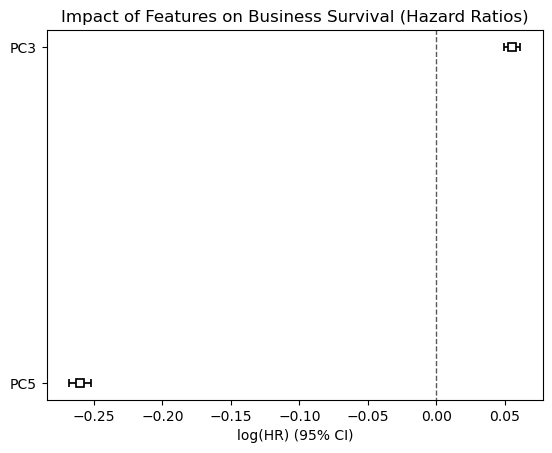

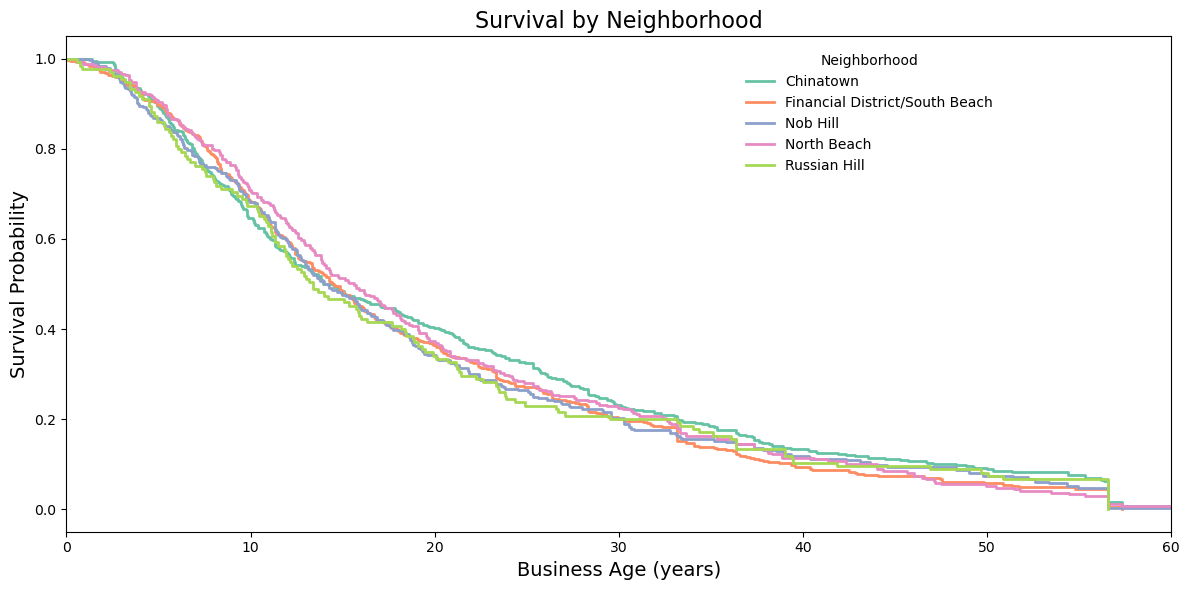

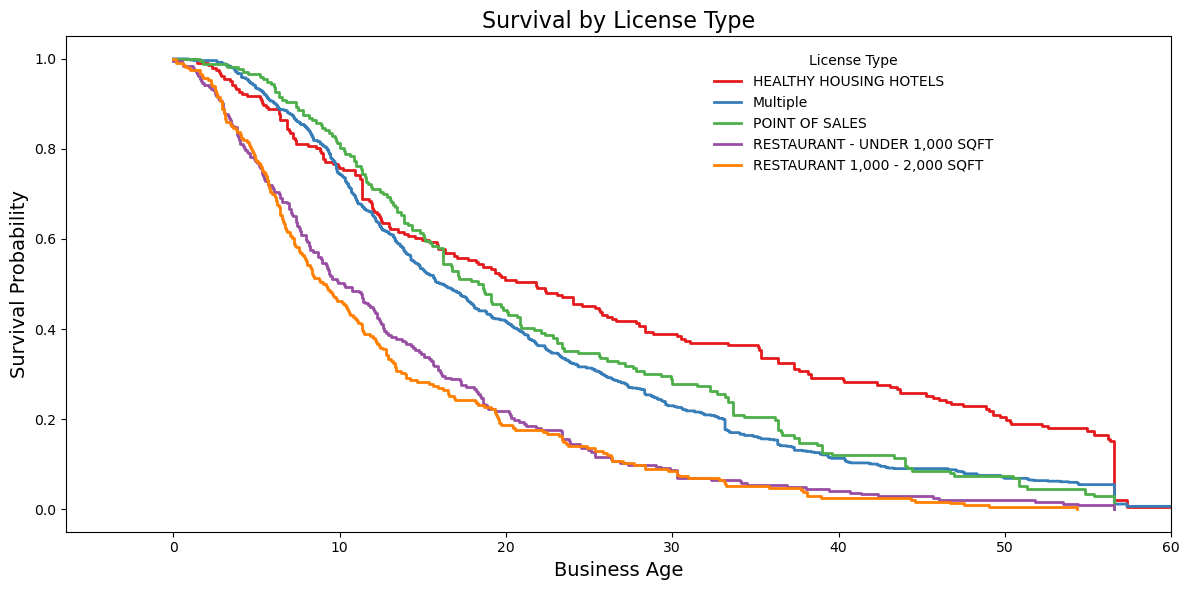

In [7]:
# ========================================================================
# This Model is only for visual Representation not for Final Production
# ========================================================================

df = sfo_df.copy()
df['business_age'] = pd.to_numeric(df['business_age'], errors='coerce')
df['administratively_closed'] = pd.to_numeric(df['administratively_closed'], errors='coerce')
df_clean = df.dropna(subset=['business_age', 'administratively_closed'])
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64', 'bool']).drop(columns=['business_age']).fillna(0)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_cols)
pca = PCA(n_components=5)
pca_data = pca.fit_transform(scaled_data)
df_clean['PC3'] = pca_data[:, 0]
df_clean['PC5'] = pca_data[:, 1]
cph_data = df_clean[['business_age', 'administratively_closed', 'PC3', 'PC5']]
cph = CoxPHFitter()
cph.fit(cph_data, duration_col='business_age', event_col='administratively_closed')
cph.print_summary()
# Print model score
print(f"Concordance Index: {cph.concordance_index_:.4f}")
cph.plot()
plt.title('Impact of Features on Business Survival (Hazard Ratios)')
plt.show()
df_top = df_clean[
    df_clean['neighborhoods_analysis_boundaries'].isin(df_clean['neighborhoods_analysis_boundaries'].value_counts().nlargest(5).index) &
    df_clean['lic_code_description'].isin(df_clean['lic_code_description'].value_counts().nlargest(5).index)
]

# ===============================================
# Visualize Kaplan-Meier curves by neighborhood
# ===============================================


kmf = KaplanMeierFitter()
plt.figure(figsize=(12, 6))

palette = sns.color_palette("Set2", len(df_top['neighborhoods_analysis_boundaries'].unique()))

for (name, grouped_df), color in zip(df_top.groupby('neighborhoods_analysis_boundaries'), palette):
    kmf.fit(grouped_df['business_age'], grouped_df['administratively_closed'], label=name)
    kmf.plot(ci_show=False, color=color, linestyle='-', linewidth=2)

plt.title("Survival by Neighborhood", fontsize=16)
plt.xlim(left=0, right=60)
plt.xticks(np.arange(0, 61, 10)) 
plt.xlabel("Business Age (years)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.legend(title='Neighborhood', loc='upper right', bbox_to_anchor=(0.85, 0.99), frameon=False)
plt.tight_layout()
plt.show()

# ===============================================
# Visualize Kaplan-Meier curves by license type
# ===============================================

plt.figure(figsize=(12, 6))
license_palette = sns.color_palette("Set1", len(df_top['lic_code_description'].unique()))
for (name, grouped_df), color in zip(df_top.groupby('lic_code_description'), license_palette):
    kmf.fit(grouped_df['business_age'], grouped_df['administratively_closed'], label=name)
    kmf.plot(ci_show=False, color=color, linestyle='-', linewidth=2)
plt.title("Survival by License Type", fontsize=16)
plt.xlim(right=60)
plt.xlabel("Business Age", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.legend(title='License Type', loc='upper right', bbox_to_anchor=(0.85, 0.99), frameon=False)
plt.tight_layout()



# ===============================================
# Save png!
# ===============================================

plt.savefig('../data/visualization.png', bbox_inches='tight')
plt.show()




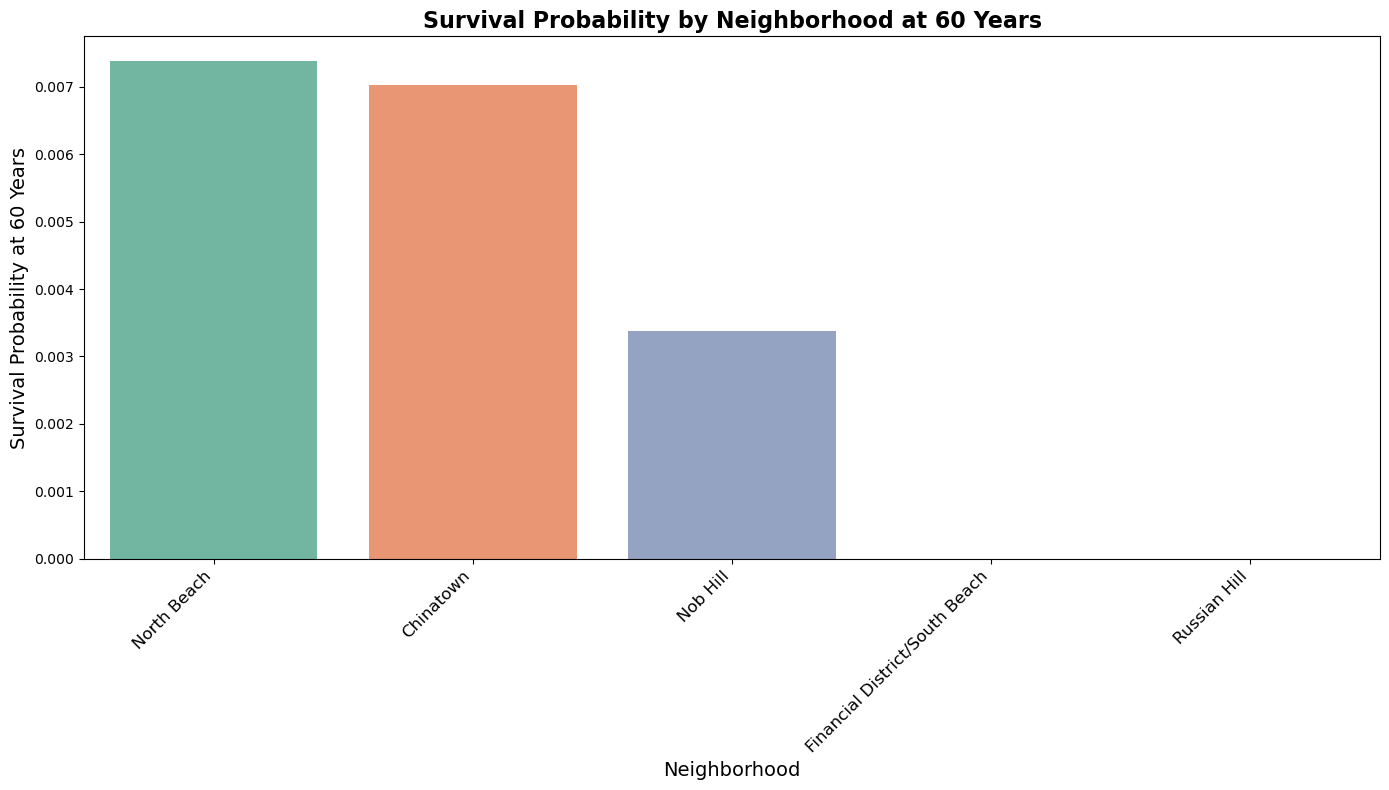

In [8]:
# ==========
# Visuals!
# ==========

kmf = KaplanMeierFitter()
time_point = 60  

# ===============================================
# Dictionary to hold survival probabilities
# ===============================================

survival_probs = {}

# ================================
# Loop through each neighborhood
# ================================
for name, grouped_df in df_top.groupby('neighborhoods_analysis_boundaries'):
    kmf.fit(grouped_df['business_age'], grouped_df['administratively_closed'])
    # Estimate survival probability at time_point (e.g., 60 years)
    survival_probs[name] = kmf.predict(time_point)

# ==================================
# Convert to DataFrame for plotting
# ==================================
survival_df = pd.DataFrame.from_dict(survival_probs, orient='index', columns=['Survival_Probability'])
survival_df = survival_df.sort_values(by='Survival_Probability', ascending=False)

# ==================
# Plot as bar chart
# ==================
plt.figure(figsize=(14, 8))
sns.barplot(x=survival_df.index, y='Survival_Probability', data=survival_df, palette='Set2')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylabel('Survival Probability at 60 Years', fontsize=14)
plt.xlabel('Neighborhood', fontsize=14)
plt.title('Survival Probability by Neighborhood at 60 Years', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


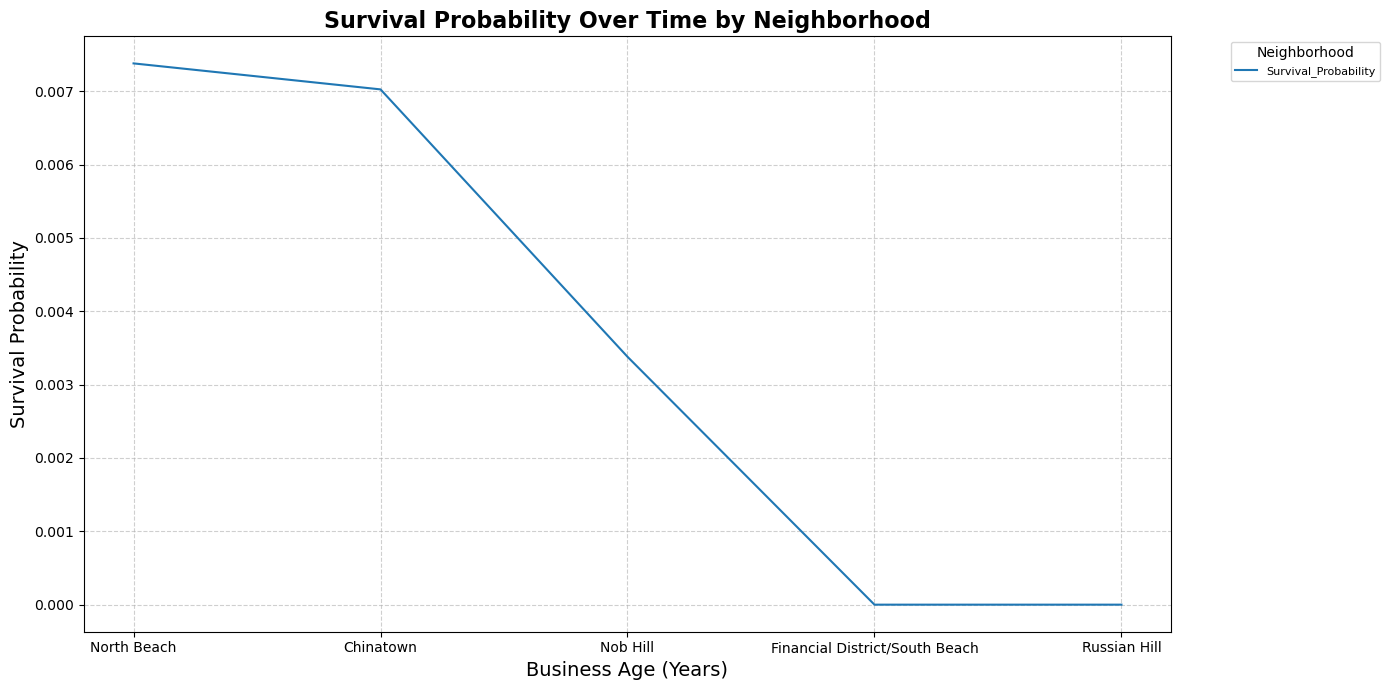

In [9]:
# ===========================================================
# Survival Probability Over Time by Neighborhood Visuals
# ===========================================================
plt.figure(figsize=(14, 7))
for neighborhood in survival_df.columns:
    plt.plot(survival_df.index, survival_df[neighborhood], label=neighborhood)
plt.xlabel("Business Age (Years)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Probability Over Time by Neighborhood", fontsize=16, fontweight='bold')
plt.legend(title="Neighborhood", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [10]:
# ======
#save!
# ======
joblib.dump(scaler, '../pkl/visual_scaler.pkl')
joblib.dump(pca, '../pkl/visual_pca.pkl')
joblib.dump(cph, '../pkl/visual_cox_model.pkl')

# ===============================================================
# Save the cleaned DataFrame with PC3 and PC5 for visualization
# ===============================================================
df_clean[['PC3', 'PC5', 'business_age', 'administratively_closed',
          'neighborhoods_analysis_boundaries', 'lic_code_description']] \
    .to_csv('../data/visual_model_dataset.csv', index=False)


## Observations on Business Survival Analysis

### Survival Probability by Neighborhood

- **Chinatown**: 
  - **Observation**: The survival probability of businesses in **Chinatown** shows a **high likelihood of survival**. The businesses in this neighborhood have a **50% probability of surviving up to 20 years**. This indicates a relatively long lifespan for businesses in Chinatown, suggesting a stable business environment.
  - **Key Insight**: Chinatown businesses are more likely to endure for extended periods, with a notable probability of surviving beyond 20 years.

- **Restaurant License Type (1,000 - 2,000 SQFT)**:
  - **Observation**: The businesses with a **restaurant license type** and a size of **1,000 - 2,000 SQFT** have a **lower survival probability**, with many of these businesses closing at a higher rate within a shorter time frame.
  - **Key Insight**: Smaller restaurant businesses in this size range are at a **higher risk of administrative closure**, showing a shorter lifespan compared to other license types or neighborhoods.

### Survival Probability by License Type

- **Healthy Housing Hotels**:
  - **Observation**: The **Healthy Housing Hotels** license type has a relatively **long survival probability**, with a **40% chance of surviving up to 35 years**. This suggests that businesses within this license type tend to be more stable and long-lasting.
  - **Key Insight**: Hotels operating under the **Healthy Housing** license category have a higher likelihood of maintaining operations for an extended period compared to other businesses.

- **Russian Hill Neighborhood**:
  - **Observation**: The businesses in the **Russian Hill** neighborhood exhibit a **lower survival probability**, with a **45% chance of surviving less than 20 years**. This indicates that businesses in this neighborhood are at a **higher risk of closure** within the first two decades of operation.
  - **Key Insight**: **Russian Hill** businesses tend to close at a faster rate, suggesting a more volatile business environment compared to other neighborhoods.

### Summary:
- **Chinatown** businesses demonstrate a long survival probability, surviving up to 20 years or more at a rate of 50%.
- **Healthy Housing Hotels** show strong longevity, with many businesses surviving up to 35 years.
- **Smaller restaurants** (1,000 - 2,000 SQFT) face a higher risk of closure, indicating that size and type may influence business longevity.
- **Russian Hill** businesses are at a greater risk of early closure, with a significant portion of businesses surviving less than 20 years.


In [11]:
# ===============================================================
# Predict average survival function over the dataset
# ===============================================================
cox_surv_func = cph.predict_survival_function(cph_data).mean(axis=1)

# ============
# Save to CSV
# ============
cox_surv_df = cox_surv_func.reset_index()
cox_surv_df.columns = ['business_age', 'survival_probability']
cox_surv_df.to_csv('../data/cox_avg_survival_curve.csv', index=False)



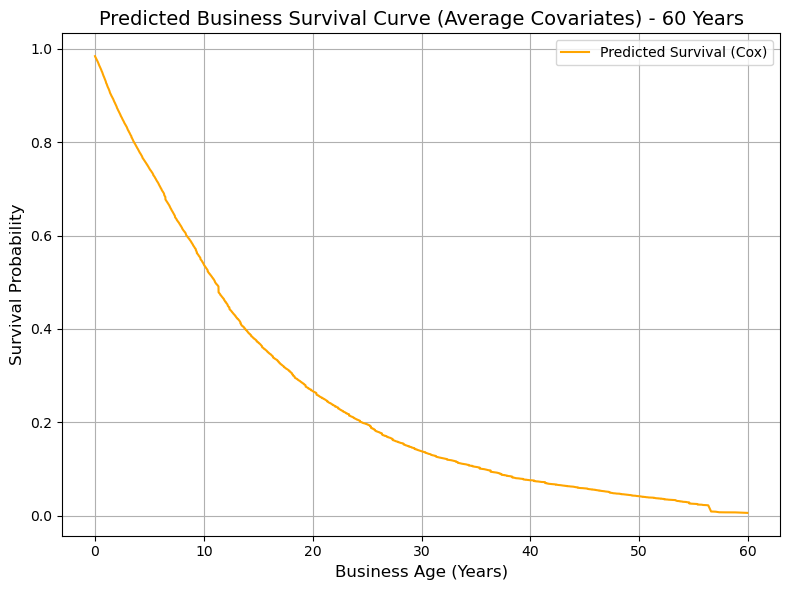

In [12]:
# =====================================================================
# Predicted Business Survival Curve (Average Covariates) - 60 Years
# =====================================================================
avg_covariates = X_train.mean().to_frame().T 
cox_surv_func = cph.predict_survival_function(avg_covariates)
cox_surv_func_60 = cox_surv_func.loc[cox_surv_func.index <= 60]
plt.figure(figsize=(8, 6))
plt.plot(cox_surv_func_60.index, cox_surv_func_60.values.flatten(), label='Predicted Survival (Cox)', color='orange')
plt.title('Predicted Business Survival Curve (Average Covariates) - 60 Years', fontsize=14)
plt.xlabel('Business Age (Years)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/cox_avg_survival_curve_60_years.png')  
plt.show()  


## Predicted Business Survival Curve (Average Covariates)

- **Overview**: The predicted **business survival curve** for **San Francisco registered businesses** indicates the **average survival age** and associated **survival probability** based on the current data of registered businesses.

- **Predicted Survival Age**: 
  - The average **predicted survival age** for **San Francisco businesses** is **25 years**. This means that, on average, businesses in San Francisco are expected to survive for about 25 years before they are administratively closed or cease operations.

- **Survival Probability**:
  - The **survival probability** for businesses reaching this age is approximately **20%**. This suggests that only **20%** of businesses in San Francisco will continue to operate beyond 25 years, with the remaining 80% likely to face administrative closure or other factors leading to business shutdowns.

### Key Insights:
- Businesses in San Francisco, on average, have a **moderate survival rate**, with a significant proportion facing closure before reaching the 25-year mark.
- The **predicted survival age** and **survival probability** can help inform strategic decisions for business owners and policymakers regarding business longevity and the need for support systems to prolong business lifespans.
